In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

from plotting import plot_utils, summary_plots, load_fits, plot_prf_params
plot_utils.set_all_font_sizes(20)
from utils import roi_utils, default_paths, stats_utils, nsd_utils

In [2]:
# Load results of the fitting procedure

subjects = np.arange(1,9)
n_subjects = len(subjects)

fitting_type = 'gabor_solo_ridge_12ori_8sf_plus_sketch_tokens'

out = [load_fits.load_fit_results(subject=ss, fitting_type=fitting_type, n_from_end=0, verbose=False) for ss in subjects]
fig_save_folder=None

# initialize roi_def objects to get roi indices
roi_def = roi_utils.multi_subject_roi_def(subjects)
roi_names =roi_def.roi_names
n_rois = roi_def.n_rois


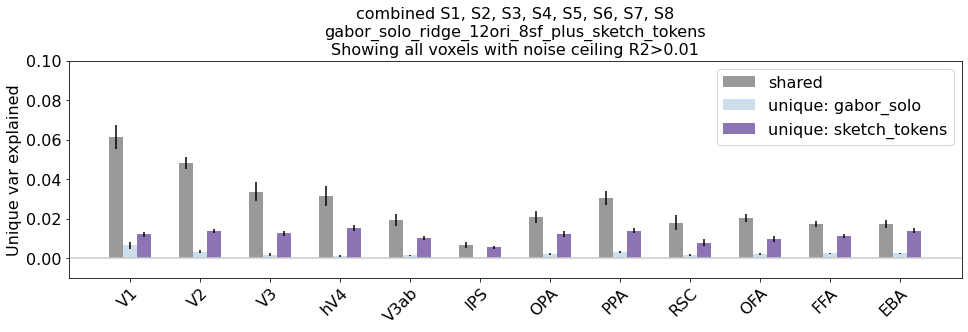

In [7]:
# Make a barplot for variance partition across all ROIs and subjects

nc_thresh = 0.01

pp0 = 0
pp1 = 1
pp2 = 2


name1 = out[0]['partial_version_names'][pp1].split('just_')[1]
name2 = out[0]['partial_version_names'][pp2].split('just_')[1]

ve_names = ['shared', 'unique: ' + name1, 'unique: ' + name2]

gray_color = np.array([[0.6, 0.6, 0.6, 1]])
vis_color1 = cm.BuPu(np.linspace(0,1,6))[1:2,:]
vis_color2 = cm.BuPu(np.linspace(0,1,6))[3:4,:]
colors = np.concatenate([gray_color, vis_color1, vis_color2], axis=0)

vals = np.zeros((n_subjects, n_rois, 3))

for si, ss in enumerate(subjects):
    
    val_r2 = out[si]['val_r2']    
    nc = nsd_utils.ncsnr_to_nc(out[si]['voxel_ncsnr'][out[si]['voxel_mask']])/100
    inds2use = nc>nc_thresh
    shared_ab, unique_a, unique_b = stats_utils.get_shared_unique_var(val_r2[:,pp0], val_r2[:,pp1], val_r2[:,pp2])
    var_expl = np.array([shared_ab, unique_a, unique_b]).T

    for ri in range(n_rois):
        
        inds_this_roi = roi_def.ss_roi_defs[si].get_indices(ri) & inds2use
        if np.sum(inds_this_roi)==0:
            print('subj %d %s has no voxels'%(ss, roi_names[ri]))
            vals[si,ri,:] = np.nan
            
        vals[si,ri,:] = np.mean(var_expl[inds_this_roi,:], axis=0)
        
mean_vals = np.mean(vals, axis=0)
sem_vals = np.std(vals, axis=0) / np.sqrt(n_subjects)

legend_separate=True
title='%s\n%s\nShowing all voxels with noise ceiling R2>%.2f'%(summary_plots.get_substr(out), \
                                                                       fitting_type, nc_thresh)

plt.rcParams['pdf.fonttype']=42
plot_utils.set_all_font_sizes(fs = 16)

fh = plot_utils.plot_multi_bars(mean_data=mean_vals, err_data=sem_vals, \
                           colors=colors, space=0.2, \
                xticklabels=roi_names, ylabel='Unique var explained', \
                ylim=[-0.01, 0.10], title=title, horizontal_line_pos=0,\
                legend_labels=np.array(ve_names), \
                legend_overlaid=True, legend_separate=False, \
                fig_size=(16,4))

fn2save = '/user_data/mmhender/imStat/figures/gabor_sketch_varpart.pdf'
plt.savefig(fn2save)


